In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../retail_food_waste_data.csv")

df.head()



,Date,Day_of_Week,Item,Category,Produced_Qty,Sold_Qty,Waste_Qty,Price_Per_Unit,Revenue,Waste_Loss,Expiry_Days
0,2023-10-01,Sunday,Bread,Bakery,142,129,13,30,3870,390,1
1,2023-10-01,Sunday,Cake,Bakery,61,54,7,350,18900,2450,2
2,2023-10-01,Sunday,Pastry,Bakery,88,66,22,60,3960,1320,1
3,2023-10-01,Sunday,Sandwich,FastFood,132,109,23,90,9810,2070,1
4,2023-10-01,Sunday,Burger,FastFood,119,99,20,120,11880,2400,1


In [3]:
df.shape


(1840, 11)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1840 non-null   object
 1   Day_of_Week     1840 non-null   object
 2   Item            1840 non-null   object
 3   Category        1840 non-null   object
 4   Produced_Qty    1840 non-null   int64 
 5   Sold_Qty        1840 non-null   int64 
 6   Waste_Qty       1840 non-null   int64 
 7   Price_Per_Unit  1840 non-null   int64 
 8   Revenue         1840 non-null   int64 
 9   Waste_Loss      1840 non-null   int64 
 10  Expiry_Days     1840 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 158.3+ KB


In [5]:
df.describe()


,Produced_Qty,Sold_Qty,Waste_Qty,Price_Per_Unit,Revenue,Waste_Loss,Expiry_Days
count,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000,1840.000000
mean,109.564130,98.291304,11.272826,84.250000,5895.016304,953.959239,1.650000
std,58.007193,58.224322,6.077040,73.339012,2843.390847,923.481362,1.388722
min,25.000000,15.000000,0.000000,20.000000,2080.000000,0.000000,0.000000
25%,71.000000,60.000000,6.000000,33.750000,3710.000000,300.000000,1.000000
50%,94.000000,82.000000,10.000000,65.000000,5160.000000,600.000000,1.000000
75%,132.000000,119.000000,16.000000,112.500000,7480.000000,1320.000000,2.000000
max,335.000000,329.000000,24.000000,350.000000,19600.000000,4900.000000,7.000000


In [6]:
(df["Sold_Qty"] > df["Produced_Qty"]).sum()


np.int64(0)

In [7]:
df.isnull().sum()


Date              0
Day_of_Week       0
Item              0
Category          0
Produced_Qty      0
Sold_Qty          0
Waste_Qty         0
Price_Per_Unit    0
Revenue           0
Waste_Loss        0
Expiry_Days       0
dtype: int64

In [8]:
# Demand Variability (Standard Deviation of Sales per Item)

variability = df.groupby("Item")["Sold_Qty"].std().reset_index()
variability.columns = ["Item", "Demand_Variability"]

variability.head()


,Item,Demand_Variability
0,Bread,13.978757
1,Brownie,11.361308
2,Bun,14.558919
3,Burger,12.909180
4,Cake,10.651827


In [9]:
## Waste Percentage per Item

waste_summary = df.groupby("Item")[["Produced_Qty", "Waste_Qty"]].sum().reset_index()
waste_summary["Waste_Percentage"] = (waste_summary["Waste_Qty"] / waste_summary["Produced_Qty"]) * 100

waste_summary.head()


,Item,Produced_Qty,Waste_Qty,Waste_Percentage
0,Bread,11564,1388,12.002767
1,Brownie,5694,328,5.760450
2,Bun,13778,1419,10.299027
3,Burger,8859,1347,15.204876
4,Cake,4005,786,19.625468


In [10]:
## Merge Variability + Waste

risk_df = pd.merge(waste_summary, variability, on="Item")
risk_df.head()


,Item,Produced_Qty,Waste_Qty,Waste_Percentage,Demand_Variability
0,Bread,11564,1388,12.002767,13.978757
1,Brownie,5694,328,5.760450,11.361308
2,Bun,13778,1419,10.299027,14.558919
3,Burger,8859,1347,15.204876,12.909180
4,Cake,4005,786,19.625468,10.651827


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

risk_df[["Waste_Score", "Variability_Score"]] = scaler.fit_transform(
    risk_df[["Waste_Percentage", "Demand_Variability"]]
)

risk_df.head()


,Item,Produced_Qty,Waste_Qty,Waste_Percentage,Demand_Variability,Waste_Score,Variability_Score
0,Bread,11564,1388,12.002767,13.978757,0.454802,0.306259
1,Brownie,5694,328,5.760450,11.361308,0.162360,0.065311
2,Bun,13778,1419,10.299027,14.558919,0.374984,0.359665
3,Burger,8859,1347,15.204876,12.909180,0.604815,0.207799
4,Cake,4005,786,19.625468,10.651827,0.811911,0.000000


In [12]:
## Overstock Risk Score

risk_df["Overstock_Risk_Score"] = (
    0.6 * risk_df["Waste_Score"] +
    0.4 * risk_df["Variability_Score"]
)

risk_df.sort_values("Overstock_Risk_Score", ascending=False).head()


,Item,Produced_Qty,Waste_Qty,Waste_Percentage,Demand_Variability,Waste_Score,Variability_Score,Overstock_Risk_Score
5,Cold Coffee,5516,1304,23.640319,12.560033,1.000000,0.175659,0.670264
19,Wrap,7413,1276,17.213004,13.390613,0.698892,0.252118,0.520182
13,Pizza Slice,6767,1234,18.235555,12.245279,0.746796,0.146684,0.506752
12,Pastry,7743,1305,16.853933,13.035015,0.682070,0.219383,0.496995
4,Cake,4005,786,19.625468,10.651827,0.811911,0.000000,0.487147


<Figure size 1000x500 with 0 Axes>

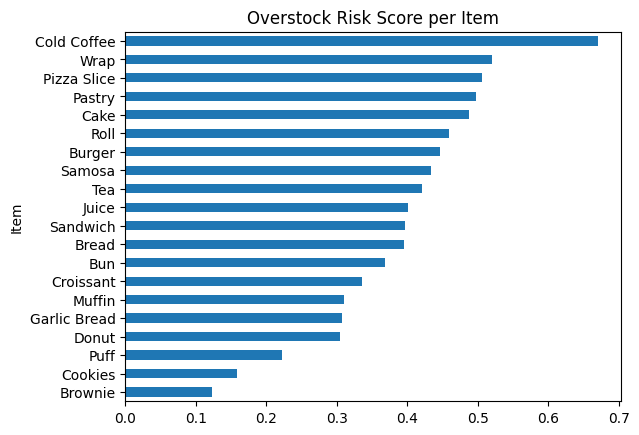

In [13]:
plt.figure(figsize=(10,5))
risk_df.sort_values("Overstock_Risk_Score").plot(
    x="Item",
    y="Overstock_Risk_Score",
    kind="barh",
    legend=False
)
plt.title("Overstock Risk Score per Item")
plt.show()


In [14]:
def categorize_risk(score):
    if score >= 0.7:
        return "High Risk"
    elif score >= 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

risk_df["Risk_Category"] = risk_df["Overstock_Risk_Score"].apply(categorize_risk)

risk_df.sort_values("Overstock_Risk_Score", ascending=False)


,Item,Produced_Qty,Waste_Qty,Waste_Percentage,Demand_Variability,Waste_Score,Variability_Score,Overstock_Risk_Score,Risk_Category
5,Cold Coffee,5516,1304,23.640319,12.560033,1.000000,0.175659,0.670264,Medium Risk
19,Wrap,7413,1276,17.213004,13.390613,0.698892,0.252118,0.520182,Medium Risk
13,Pizza Slice,6767,1234,18.235555,12.245279,0.746796,0.146684,0.506752,Medium Risk
12,Pastry,7743,1305,16.853933,13.035015,0.682070,0.219383,0.496995,Medium Risk
4,Cake,4005,786,19.625468,10.651827,0.811911,0.000000,0.487147,Medium Risk
15,Roll,9231,1292,13.996317,14.181351,0.548196,0.324909,0.458881,Medium Risk
3,Burger,8859,1347,15.204876,12.909180,0.604815,0.207799,0.446009,Medium Risk
16,Samosa,19393,1329,6.852988,18.964649,0.213544,0.765233,0.434219,Medium Risk
18,Tea,26366,798,3.026625,21.514959,0.034285,1.000000,0.420571,Medium Risk
10,Juice,10570,1336,12.639546,13.655669,0.484633,0.276517,0.401387,Medium Risk


In [15]:
risk_df["Risk_Category"].value_counts()


Risk_Category
Low Risk       10
Medium Risk    10
Name: count, dtype: int64

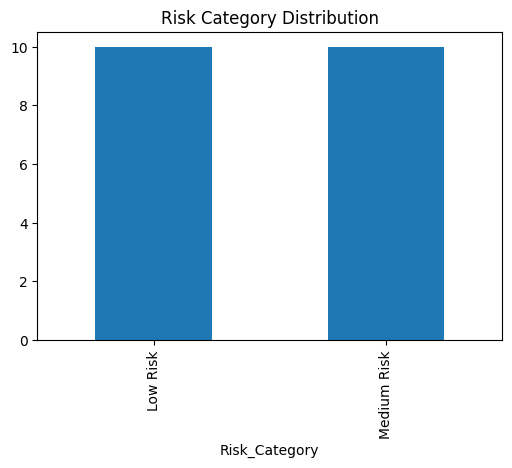

In [16]:
plt.figure(figsize=(6,4))
risk_df["Risk_Category"].value_counts().plot(kind="bar")
plt.title("Risk Category Distribution")
plt.show()


In [ ]:
##Total Waste Loss
total_waste_loss = df["Waste_Loss"].sum()
print("Total Waste Loss (₹):", total_waste_loss)


Total Waste Loss (₹): 1755285


In [18]:
## High Risk Items Ka Total Loss

high_risk_items = risk_df[risk_df["Risk_Category"] == "High Risk"]["Item"]

high_risk_loss = df[df["Item"].isin(high_risk_items)]["Waste_Loss"].sum()

print("High Risk Items Total Loss (₹):", high_risk_loss)


High Risk Items Total Loss (₹): 0


In [19]:
## Hypothetical Improvement Scenario

potential_savings = total_waste_loss * 0.15

print("Potential Savings if Waste Reduced by 15% (₹):", potential_savings)


Potential Savings if Waste Reduced by 15% (₹): 263292.75


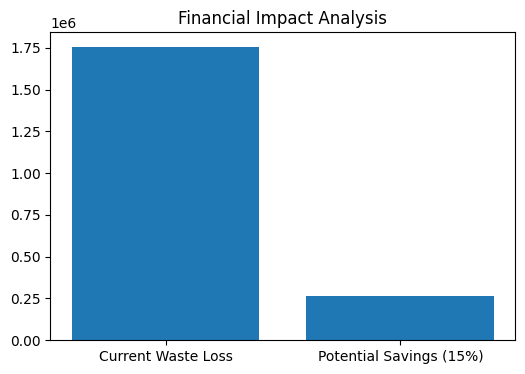

In [20]:
labels = ["Current Waste Loss", "Potential Savings (15%)"]
values = [total_waste_loss, potential_savings]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Financial Impact Analysis")
plt.show()
